In [2]:
# 먼저 이 셀을 실행하세요 (한글 폰트 설치)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and direct

Pearson 상관계수: -0.3430
Spearman 상관계수: -0.4489
분석 데이터: 240개


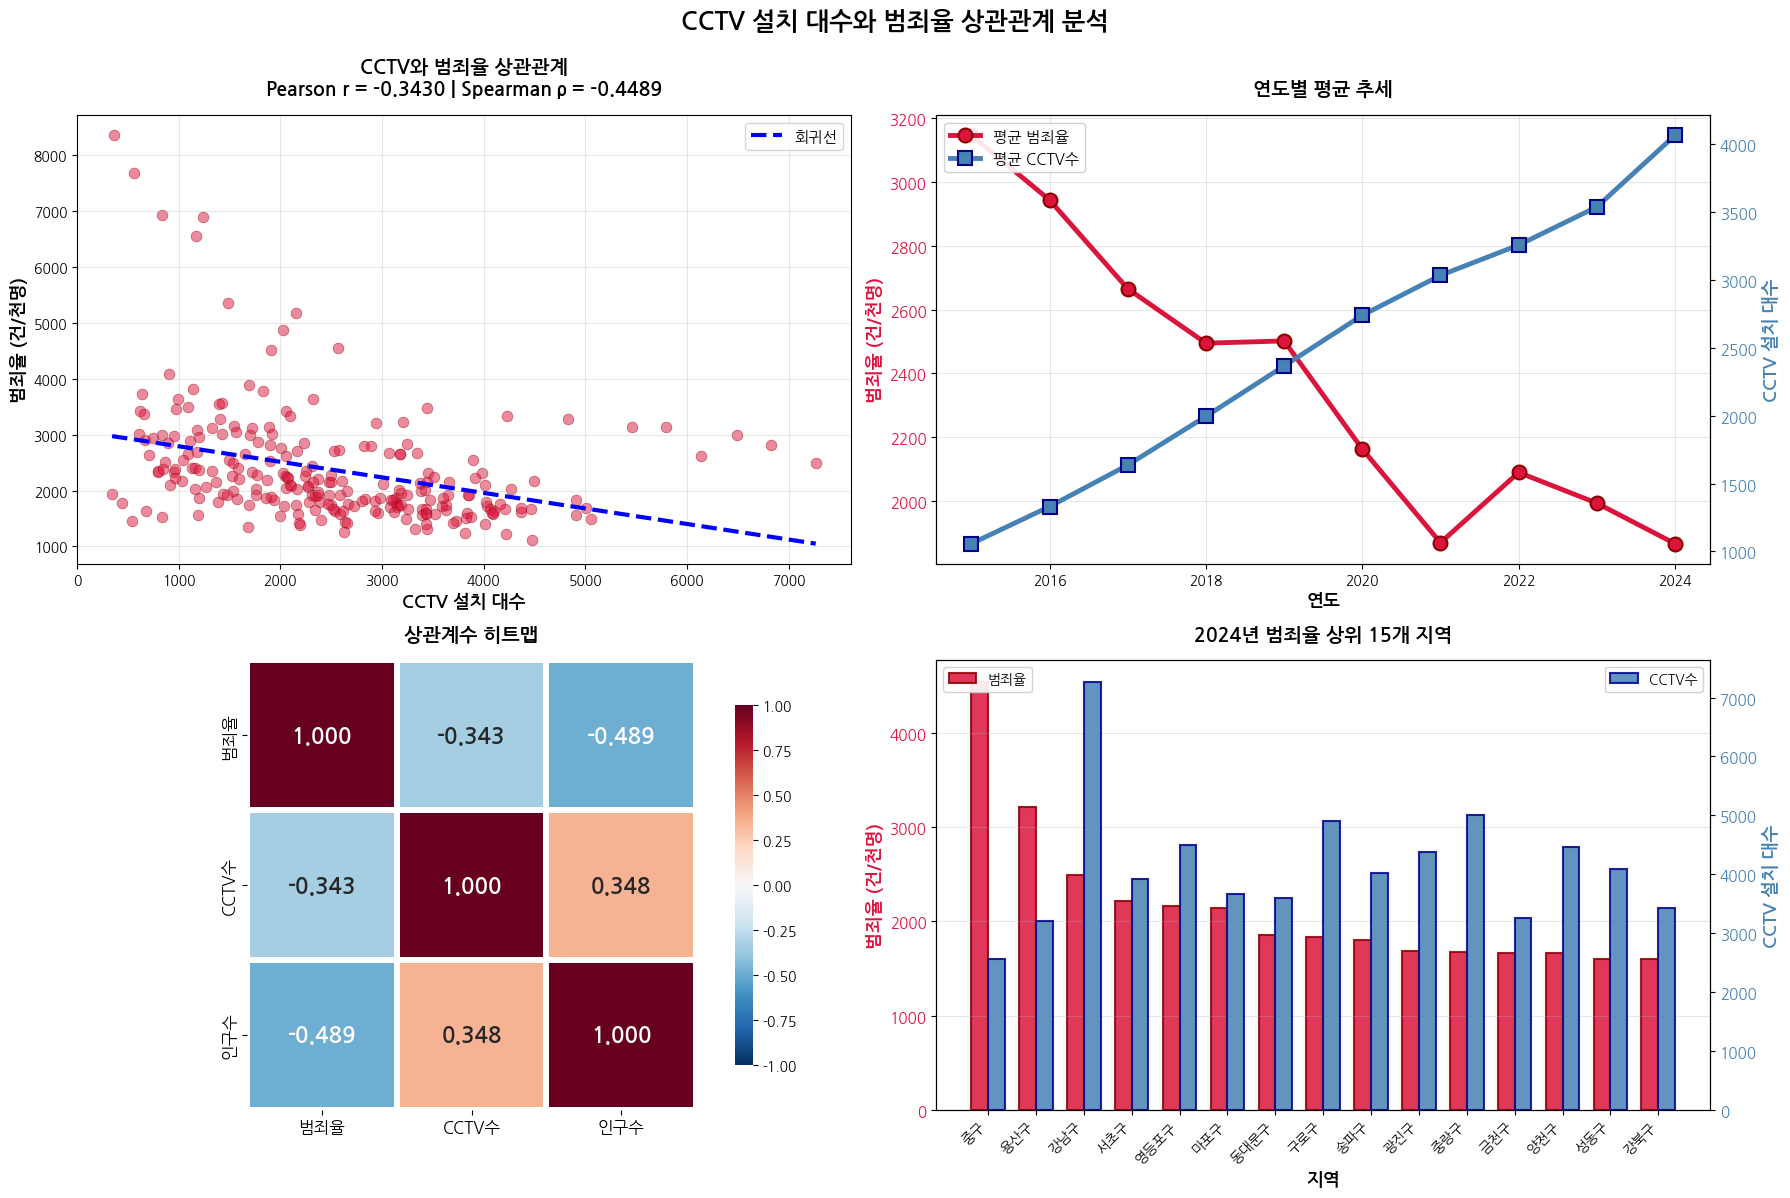

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

# ===============================
# 1. 데이터 로딩 (파일 경로는 실제 환경에 맞게 수정)
# ===============================
crime_file = '/content/crime_rate_long.csv'
cctv_file = '/content/서울시_CCTV_설치현황_long_format.csv'

df_crime = pd.read_csv(crime_file)
df_cctv = pd.read_csv(cctv_file)

# ===============================
# 2. 지역명 정규화
# ===============================
def normalize_region(text):
    if pd.isna(text):
        return None
    text = str(text).strip()
    text = text.replace('구청', '').replace('서울특별시', '').replace('서울시', '').strip()
    if not text.endswith('구'):
        text = text + '구'
    return text

# ===============================
# 3. 데이터 전처리
# ===============================
df_crime['지역'] = df_crime['region'].apply(normalize_region)
df_crime_clean = df_crime[['year', '지역', 'population', 'total', 'crime_rate']].copy()
df_crime_clean.columns = ['연도', '지역', '인구수', '범죄건수', '범죄율']

df_cctv['지역'] = df_cctv['region'].apply(normalize_region)
df_cctv_clean = df_cctv[['year', '지역', 'cumulative_cctv']].copy()
df_cctv_clean.columns = ['연도', '지역', 'CCTV수']

# ===============================
# 4. 데이터 병합
# ===============================
df_merged = df_crime_clean.merge(df_cctv_clean, on=['연도', '지역'], how='inner')
df_merged = df_merged.dropna()

# ===============================
# 5. 상관계수 계산
# ===============================
corr_pearson = df_merged['범죄율'].corr(df_merged['CCTV수'])
corr_spearman = stats.spearmanr(df_merged['범죄율'], df_merged['CCTV수'])[0]

print(f"Pearson 상관계수: {corr_pearson:.4f}")
print(f"Spearman 상관계수: {corr_spearman:.4f}")
print(f"분석 데이터: {len(df_merged)}개")

# ===============================
# 6. 시각화 (2x2 레이아웃)
# ===============================
fig = plt.figure(figsize=(18, 12))

# 산점도 + 회귀선 (상관계수)
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(df_merged['CCTV수'], df_merged['범죄율'],
            alpha=0.5, s=60, c='crimson', edgecolors='darkred', linewidth=0.5)
z = np.polyfit(df_merged['CCTV수'], df_merged['범죄율'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_merged['CCTV수'].min(), df_merged['CCTV수'].max(), 100)
ax1.plot(x_line, p(x_line), "blue", linestyle='--', linewidth=3, label='회귀선')
ax1.set_xlabel('CCTV 설치 대수', fontsize=13, weight='bold')
ax1.set_ylabel('범죄율 (건/천명)', fontsize=13, weight='bold')
ax1.set_title(f'CCTV와 범죄율 상관관계\nPearson r = {corr_pearson:.4f} | Spearman ρ = {corr_spearman:.4f}',
              fontsize=14, weight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# ===============================
# 7. 연도별 평균 추세 (이중 y축)
# ===============================
ax2 = plt.subplot(2, 2, 2)
yearly = df_merged.groupby('연도')[['범죄율', 'CCTV수']].mean()
ax2_twin = ax2.twinx()

line1 = ax2.plot(yearly.index, yearly['범죄율'],
                marker='o', linewidth=3.5, markersize=10,
                color='crimson', label='평균 범죄율', markeredgecolor='darkred', markeredgewidth=1.5)
line2 = ax2_twin.plot(yearly.index, yearly['CCTV수'],
                     marker='s', linewidth=3.5, markersize=10,
                     color='steelblue', label='평균 CCTV수', markeredgecolor='darkblue', markeredgewidth=1.5)

ax2.set_xlabel('연도', fontsize=13, weight='bold')
ax2.set_ylabel('범죄율 (건/천명)', fontsize=13, weight='bold', color='crimson')
ax2_twin.set_ylabel('CCTV 설치 대수', fontsize=13, weight='bold', color='steelblue')
ax2.set_title('연도별 평균 추세', fontsize=14, weight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='y', labelcolor='crimson', labelsize=11)
ax2_twin.tick_params(axis='y', labelcolor='steelblue', labelsize=11)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left', fontsize=11, framealpha=0.9)

# ===============================
# 8. 상관계수 히트맵
# ===============================
ax3 = plt.subplot(2, 2, 3)
corr_matrix = df_merged[['범죄율', 'CCTV수', '인구수']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, square=True, linewidths=3, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot_kws={'size': 16, 'weight': 'bold'}, ax=ax3)
ax3.set_title('상관계수 히트맵', fontsize=14, weight='bold', pad=15)
ax3.tick_params(labelsize=12)

# ===============================
# 9. 2024년 범죄율 상위 15개 지역
# ===============================
ax4 = plt.subplot(2, 2, 4)
latest_year = df_merged['연도'].max()
df_latest = df_merged[df_merged['연도'] == latest_year].copy()
df_top = df_latest.nlargest(15, '범죄율')

x = np.arange(len(df_top))
width = 0.35
ax4_twin = ax4.twinx()

bars1 = ax4.bar(x - width/2, df_top['범죄율'], width,
                label='범죄율', color='crimson', alpha=0.85, edgecolor='darkred', linewidth=1.5)
bars2 = ax4_twin.bar(x + width/2, df_top['CCTV수'], width,
                     label='CCTV수', color='steelblue', alpha=0.85, edgecolor='darkblue', linewidth=1.5)

ax4.set_xlabel('지역', fontsize=13, weight='bold')
ax4.set_ylabel('범죄율 (건/천명)', fontsize=13, weight='bold', color='crimson')
ax4_twin.set_ylabel('CCTV 설치 대수', fontsize=13, weight='bold', color='steelblue')
ax4.set_title(f'{latest_year}년 범죄율 상위 15개 지역', fontsize=14, weight='bold', pad=15)
ax4.set_xticks(x)
ax4.set_xticklabels(df_top['지역'], rotation=45, ha='right', fontsize=10)
ax4.tick_params(axis='y', labelcolor='crimson', labelsize=11)
ax4_twin.tick_params(axis='y', labelcolor='steelblue', labelsize=11)
ax4.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax4_twin.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('CCTV 설치 대수와 범죄율 상관관계 분석',
             fontsize=18, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

Pearson 상관계수: -0.3178
Spearman 상관계수: -0.3455
분석 데이터: 205개


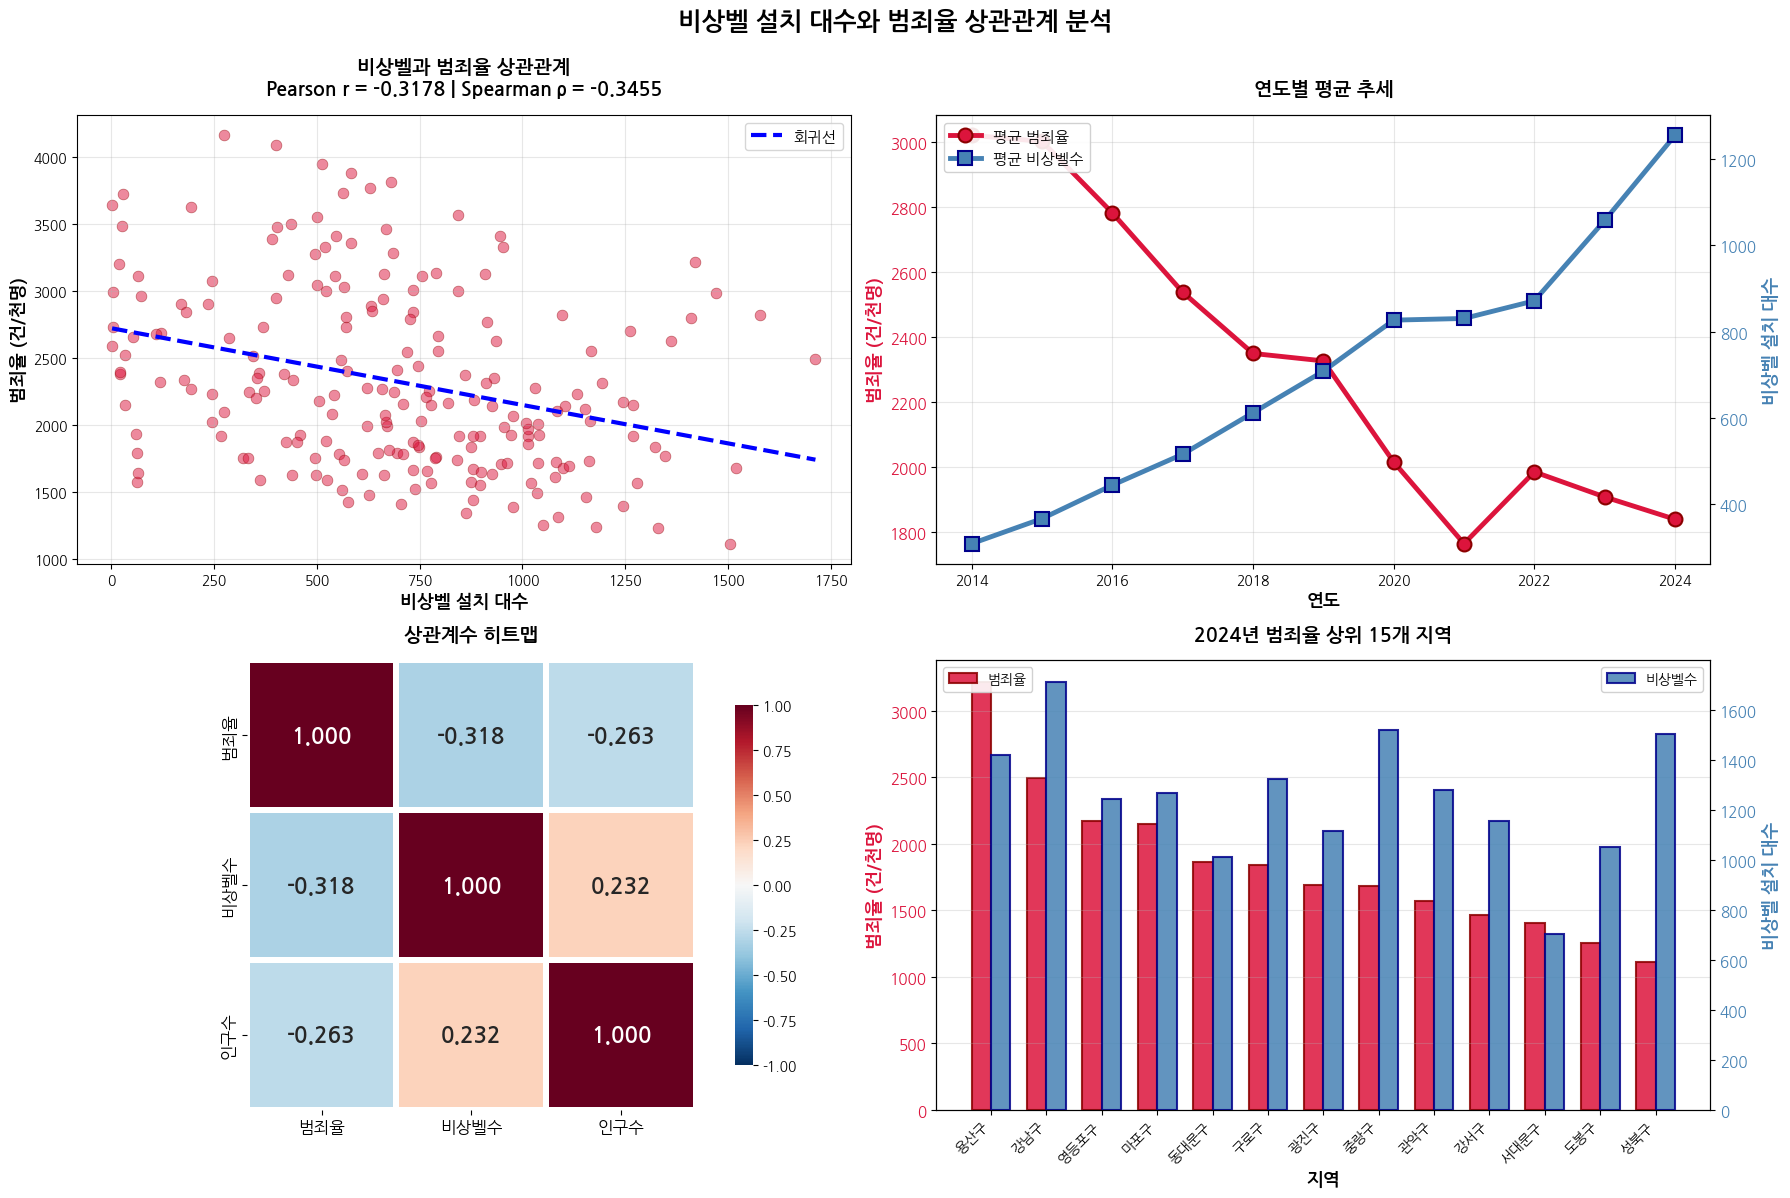

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

# ===============================
# 1. 데이터 로딩 (파일 경로는 실제 환경에 맞게 수정)
# ===============================
crime_file = '/content/crime_rate_long.csv'
bell_file = '/content/비상벨_년도별_지역별_누적설치대수.csv'

df_crime = pd.read_csv(crime_file)
df_bell = pd.read_csv(bell_file)

# ===============================
# 2. 지역명 정규화
# ===============================
def normalize_region(text):
    if pd.isna(text):
        return None
    text = str(text).strip()
    text = text.replace('구청', '').replace('서울특별시', '').replace('서울시', '').strip()
    if not text.endswith('구'):
        text = text + '구'
    return text

# ===============================
# 3. 데이터 전처리
# ===============================
df_crime['지역'] = df_crime['region'].apply(normalize_region)
df_crime_clean = df_crime[['year', '지역', 'population', 'total', 'crime_rate']].copy()
df_crime_clean.columns = ['연도', '지역', '인구수', '범죄건수', '범죄율']

df_bell['지역'] = df_bell['최종지역'].apply(normalize_region)
df_bell_clean = df_bell[['안전비상벨설치연도', '지역', '누적설치대수']].copy()
df_bell_clean.columns = ['연도', '지역', '비상벨수']

# ===============================
# 4. 데이터 병합
# ===============================
df_merged = df_crime_clean.merge(df_bell_clean, on=['연도', '지역'], how='inner')
df_merged = df_merged.dropna()

# ===============================
# 5. 상관계수 계산
# ===============================
corr_pearson = df_merged['범죄율'].corr(df_merged['비상벨수'])
corr_spearman = stats.spearmanr(df_merged['범죄율'], df_merged['비상벨수'])[0]

print(f"Pearson 상관계수: {corr_pearson:.4f}")
print(f"Spearman 상관계수: {corr_spearman:.4f}")
print(f"분석 데이터: {len(df_merged)}개")

# ===============================
# 6. 시각화 (2x2 레이아웃)
# ===============================
fig = plt.figure(figsize=(18, 12))

#  산점도 + 회귀선 (상관계수)
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(df_merged['비상벨수'], df_merged['범죄율'],
            alpha=0.5, s=60, c='crimson', edgecolors='darkred', linewidth=0.5)
z = np.polyfit(df_merged['비상벨수'], df_merged['범죄율'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_merged['비상벨수'].min(), df_merged['비상벨수'].max(), 100)
ax1.plot(x_line, p(x_line), "blue", linestyle='--', linewidth=3, label='회귀선')
ax1.set_xlabel('비상벨 설치 대수', fontsize=13, weight='bold')
ax1.set_ylabel('범죄율 (건/천명)', fontsize=13, weight='bold')
ax1.set_title(f'비상벨과 범죄율 상관관계\nPearson r = {corr_pearson:.4f} | Spearman ρ = {corr_spearman:.4f}',
              fontsize=14, weight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# ===============================
# 7. 연도별 평균 추세 (이중 y축)
# ===============================
ax2 = plt.subplot(2, 2, 2)
yearly = df_merged.groupby('연도')[['범죄율', '비상벨수']].mean()
ax2_twin = ax2.twinx()

line1 = ax2.plot(yearly.index, yearly['범죄율'],
                marker='o', linewidth=3.5, markersize=10,
                color='crimson', label='평균 범죄율', markeredgecolor='darkred', markeredgewidth=1.5)
line2 = ax2_twin.plot(yearly.index, yearly['비상벨수'],
                     marker='s', linewidth=3.5, markersize=10,
                     color='steelblue', label='평균 비상벨수', markeredgecolor='darkblue', markeredgewidth=1.5)

ax2.set_xlabel('연도', fontsize=13, weight='bold')
ax2.set_ylabel('범죄율 (건/천명)', fontsize=13, weight='bold', color='crimson')
ax2_twin.set_ylabel('비상벨 설치 대수', fontsize=13, weight='bold', color='steelblue')
ax2.set_title('연도별 평균 추세', fontsize=14, weight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='y', labelcolor='crimson', labelsize=11)
ax2_twin.tick_params(axis='y', labelcolor='steelblue', labelsize=11)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left', fontsize=11, framealpha=0.9)

# ===============================
# 8. 상관계수 히트맵
# ===============================
ax3 = plt.subplot(2, 2, 3)
corr_matrix = df_merged[['범죄율', '비상벨수', '인구수']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, square=True, linewidths=3, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot_kws={'size': 16, 'weight': 'bold'}, ax=ax3)
ax3.set_title('상관계수 히트맵', fontsize=14, weight='bold', pad=15)
ax3.tick_params(labelsize=12)

# ===============================
# 9. 2024년 범죄율 상위 15개 지역
# ===============================
ax4 = plt.subplot(2, 2, 4)
latest_year = df_merged['연도'].max()
df_latest = df_merged[df_merged['연도'] == latest_year].copy()
df_top = df_latest.nlargest(15, '범죄율')

x = np.arange(len(df_top))
width = 0.35
ax4_twin = ax4.twinx()

bars1 = ax4.bar(x - width/2, df_top['범죄율'], width,
                label='범죄율', color='crimson', alpha=0.85, edgecolor='darkred', linewidth=1.5)
bars2 = ax4_twin.bar(x + width/2, df_top['비상벨수'], width,
                     label='비상벨수', color='steelblue', alpha=0.85, edgecolor='darkblue', linewidth=1.5)

ax4.set_xlabel('지역', fontsize=13, weight='bold')
ax4.set_ylabel('범죄율 (건/천명)', fontsize=13, weight='bold', color='crimson')
ax4_twin.set_ylabel('비상벨 설치 대수', fontsize=13, weight='bold', color='steelblue')
ax4.set_title(f'{latest_year}년 범죄율 상위 15개 지역', fontsize=14, weight='bold', pad=15)
ax4.set_xticks(x)
ax4.set_xticklabels(df_top['지역'], rotation=45, ha='right', fontsize=10)
ax4.tick_params(axis='y', labelcolor='crimson', labelsize=11)
ax4_twin.tick_params(axis='y', labelcolor='steelblue', labelsize=11)
ax4.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax4_twin.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('비상벨 설치 대수와 범죄율 상관관계 분석',
             fontsize=18, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

Pearson 상관계수: 0.4569
Spearman 상관계수: 0.2355
분석 데이터: 110개


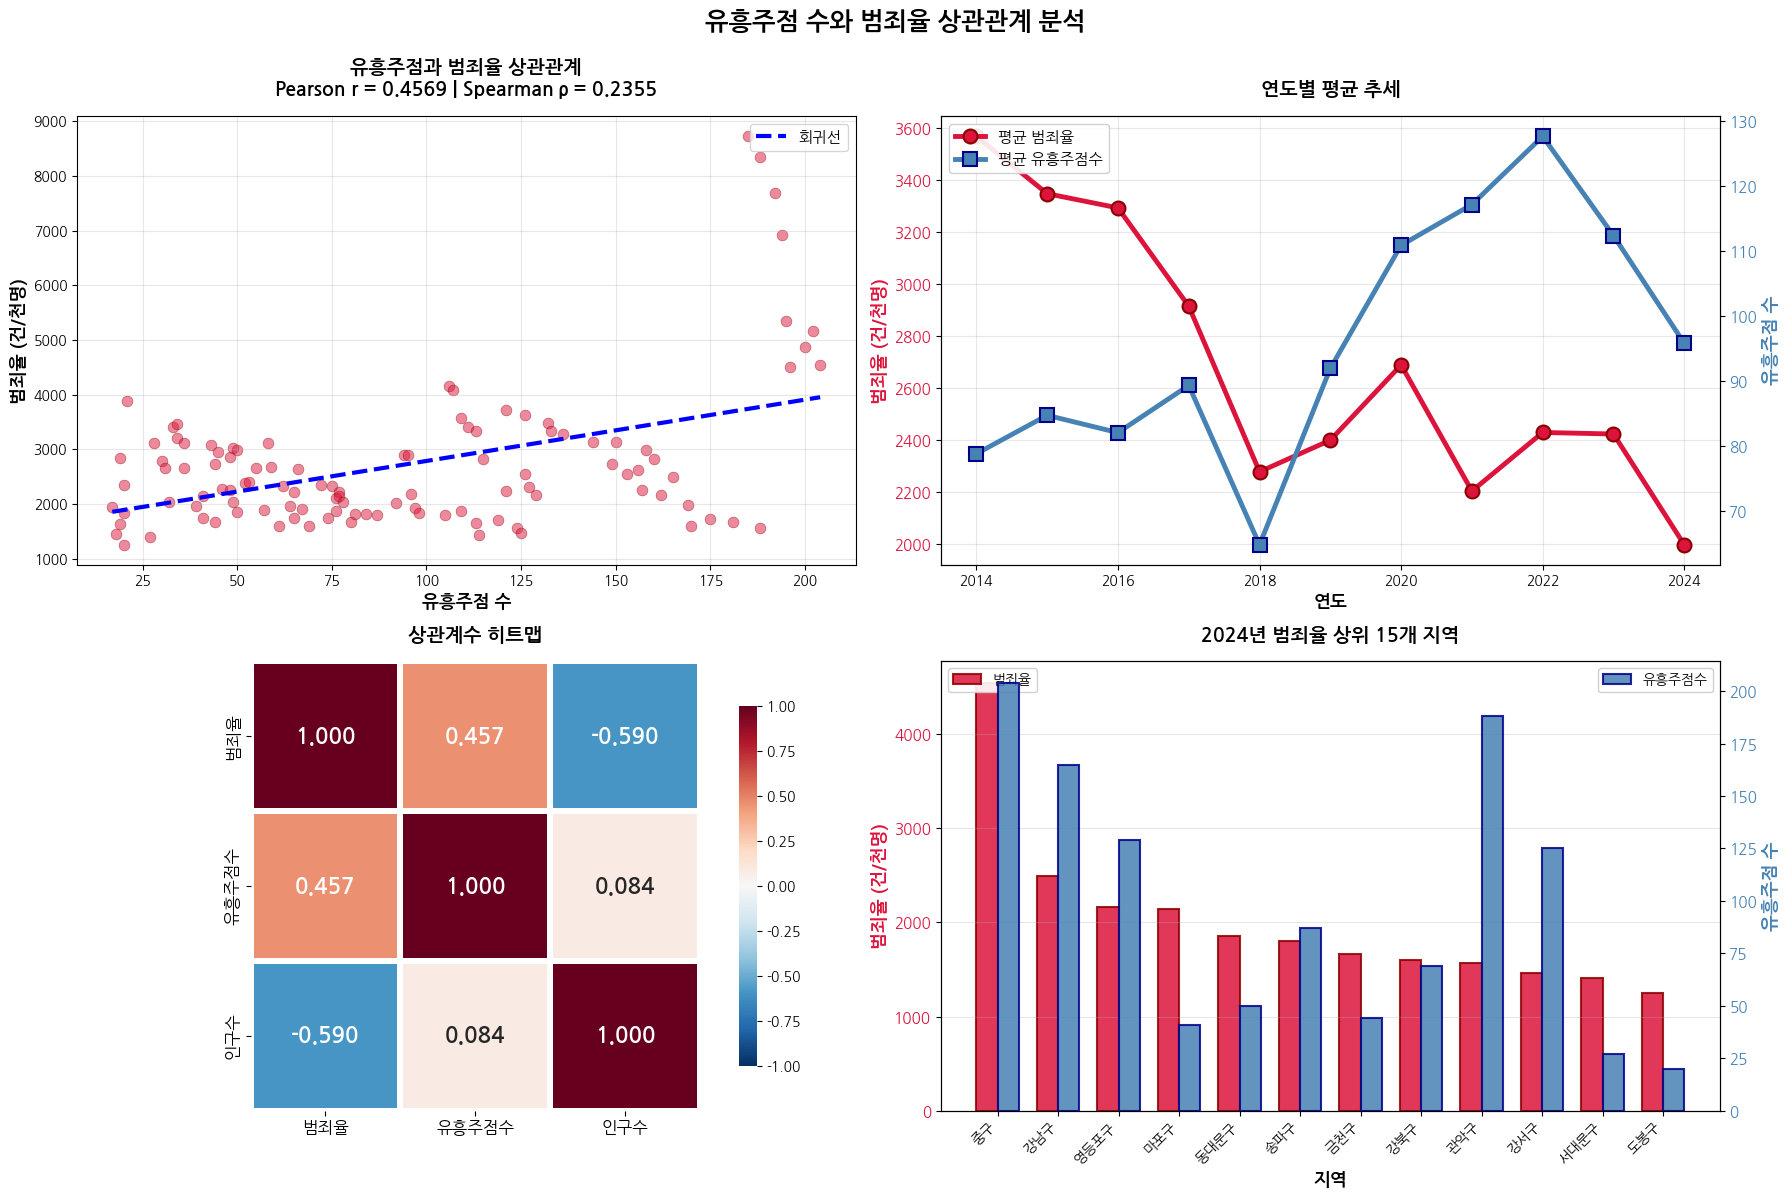

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

# ===============================
# 1. 데이터 로딩 (파일 경로는 실제 환경에 맞게 수정)
# ===============================
crime_file = '/content/crime_rate_long.csv'
bar_file = '/content/서울시_연도별_구별_유흥주점_누적집계.csv'

df_crime = pd.read_csv(crime_file)
df_bar = pd.read_csv(bar_file)

# ===============================
# 2. 지역명 정규화
# ===============================
def normalize_region(text):
    if pd.isna(text):
        return None
    text = str(text).strip()
    text = text.replace('구청', '').replace('서울특별시', '').replace('서울시', '').strip()
    if not text.endswith('구'):
        text = text + '구'
    return text

# ===============================
# 3. 데이터 전처리
# ===============================
df_crime['지역'] = df_crime['region'].apply(normalize_region)
df_crime_clean = df_crime[['year', '지역', 'population', 'total', 'crime_rate']].copy()
df_crime_clean.columns = ['연도', '지역', '인구수', '범죄건수', '범죄율']

df_bar['지역'] = df_bar['구'].apply(normalize_region)
df_bar_clean = df_bar[['연도', '지역', '누적_유흥주점수']].copy()
df_bar_clean.columns = ['연도', '지역', '유흥주점수']

# ===============================
# 4. 데이터 병합
# ===============================
df_merged = df_crime_clean.merge(df_bar_clean, on=['연도', '지역'], how='inner')
df_merged = df_merged.dropna()

# ===============================
# 5. 상관계수 계산
# ===============================
corr_pearson = df_merged['범죄율'].corr(df_merged['유흥주점수'])
corr_spearman = stats.spearmanr(df_merged['범죄율'], df_merged['유흥주점수'])[0]

print(f"Pearson 상관계수: {corr_pearson:.4f}")
print(f"Spearman 상관계수: {corr_spearman:.4f}")
print(f"분석 데이터: {len(df_merged)}개")

# ===============================
# 6. 시각화 (2x2 레이아웃)
# ===============================
fig = plt.figure(figsize=(18, 12))

# . 산점도 + 회귀선 (상관계수)
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(df_merged['유흥주점수'], df_merged['범죄율'],
            alpha=0.5, s=60, c='crimson', edgecolors='darkred', linewidth=0.5)
z = np.polyfit(df_merged['유흥주점수'], df_merged['범죄율'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_merged['유흥주점수'].min(), df_merged['유흥주점수'].max(), 100)
ax1.plot(x_line, p(x_line), "blue", linestyle='--', linewidth=3, label='회귀선')
ax1.set_xlabel('유흥주점 수', fontsize=13, weight='bold')
ax1.set_ylabel('범죄율 (건/천명)', fontsize=13, weight='bold')
ax1.set_title(f'유흥주점과 범죄율 상관관계\nPearson r = {corr_pearson:.4f} | Spearman ρ = {corr_spearman:.4f}',
              fontsize=14, weight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# ===============================
# 7. 연도별 평균 추세 (이중 y축)
# ===============================
ax2 = plt.subplot(2, 2, 2)
yearly = df_merged.groupby('연도')[['범죄율', '유흥주점수']].mean()
ax2_twin = ax2.twinx()

line1 = ax2.plot(yearly.index, yearly['범죄율'],
                marker='o', linewidth=3.5, markersize=10,
                color='crimson', label='평균 범죄율', markeredgecolor='darkred', markeredgewidth=1.5)
line2 = ax2_twin.plot(yearly.index, yearly['유흥주점수'],
                     marker='s', linewidth=3.5, markersize=10,
                     color='steelblue', label='평균 유흥주점수', markeredgecolor='darkblue', markeredgewidth=1.5)

ax2.set_xlabel('연도', fontsize=13, weight='bold')
ax2.set_ylabel('범죄율 (건/천명)', fontsize=13, weight='bold', color='crimson')
ax2_twin.set_ylabel('유흥주점 수', fontsize=13, weight='bold', color='steelblue')
ax2.set_title('연도별 평균 추세', fontsize=14, weight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='y', labelcolor='crimson', labelsize=11)
ax2_twin.tick_params(axis='y', labelcolor='steelblue', labelsize=11)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left', fontsize=11, framealpha=0.9)

# ===============================
# 8. 상관계수 히트맵
# ===============================
ax3 = plt.subplot(2, 2, 3)
corr_matrix = df_merged[['범죄율', '유흥주점수', '인구수']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, square=True, linewidths=3, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot_kws={'size': 16, 'weight': 'bold'}, ax=ax3)
ax3.set_title('상관계수 히트맵', fontsize=14, weight='bold', pad=15)
ax3.tick_params(labelsize=12)

# ===============================
# 9. 2024년 범죄율 상위 15개 지역
# ===============================
ax4 = plt.subplot(2, 2, 4)
latest_year = df_merged['연도'].max()
df_latest = df_merged[df_merged['연도'] == latest_year].copy()
df_top = df_latest.nlargest(15, '범죄율')

x = np.arange(len(df_top))
width = 0.35
ax4_twin = ax4.twinx()

bars1 = ax4.bar(x - width/2, df_top['범죄율'], width,
                label='범죄율', color='crimson', alpha=0.85, edgecolor='darkred', linewidth=1.5)
bars2 = ax4_twin.bar(x + width/2, df_top['유흥주점수'], width,
                     label='유흥주점수', color='steelblue', alpha=0.85, edgecolor='darkblue', linewidth=1.5)

ax4.set_xlabel('지역', fontsize=13, weight='bold')
ax4.set_ylabel('범죄율 (건/천명)', fontsize=13, weight='bold', color='crimson')
ax4_twin.set_ylabel('유흥주점 수', fontsize=13, weight='bold', color='steelblue')
ax4.set_title(f'{latest_year}년 범죄율 상위 15개 지역', fontsize=14, weight='bold', pad=15)
ax4.set_xticks(x)
ax4.set_xticklabels(df_top['지역'], rotation=45, ha='right', fontsize=10)
ax4.tick_params(axis='y', labelcolor='crimson', labelsize=11)
ax4_twin.tick_params(axis='y', labelcolor='steelblue', labelsize=11)
ax4.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax4_twin.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('유흥주점 수와 범죄율 상관관계 분석',
             fontsize=18, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

✓ CSV 로딩 완료
레코드 수: 120개
분석 연도: 2014 ~ 2018
분석 지역 수: 24개

컬럼: ['연도', '지역', '인구수', '범죄건수', '범죄율', '평균소득']

데이터 샘플:
     연도   지역       인구수  범죄건수      범죄율     평균소득
0  2014  강남구  237375.0  8851  3728.70  2412178
1  2014  강동구  185905.0  5392  2900.41  1898998
2  2014  강북구  141246.0  4030  2853.18  1468551
3  2014  강서구  234378.0  5289  2256.61  2121727
4  2014  관악구  248180.0  6781  2732.29  1620741

전체 기간 상관관계 분석 결과
Pearson 상관계수: 0.5710
Spearman 상관계수: 0.4866 (p-value: 0.0000)


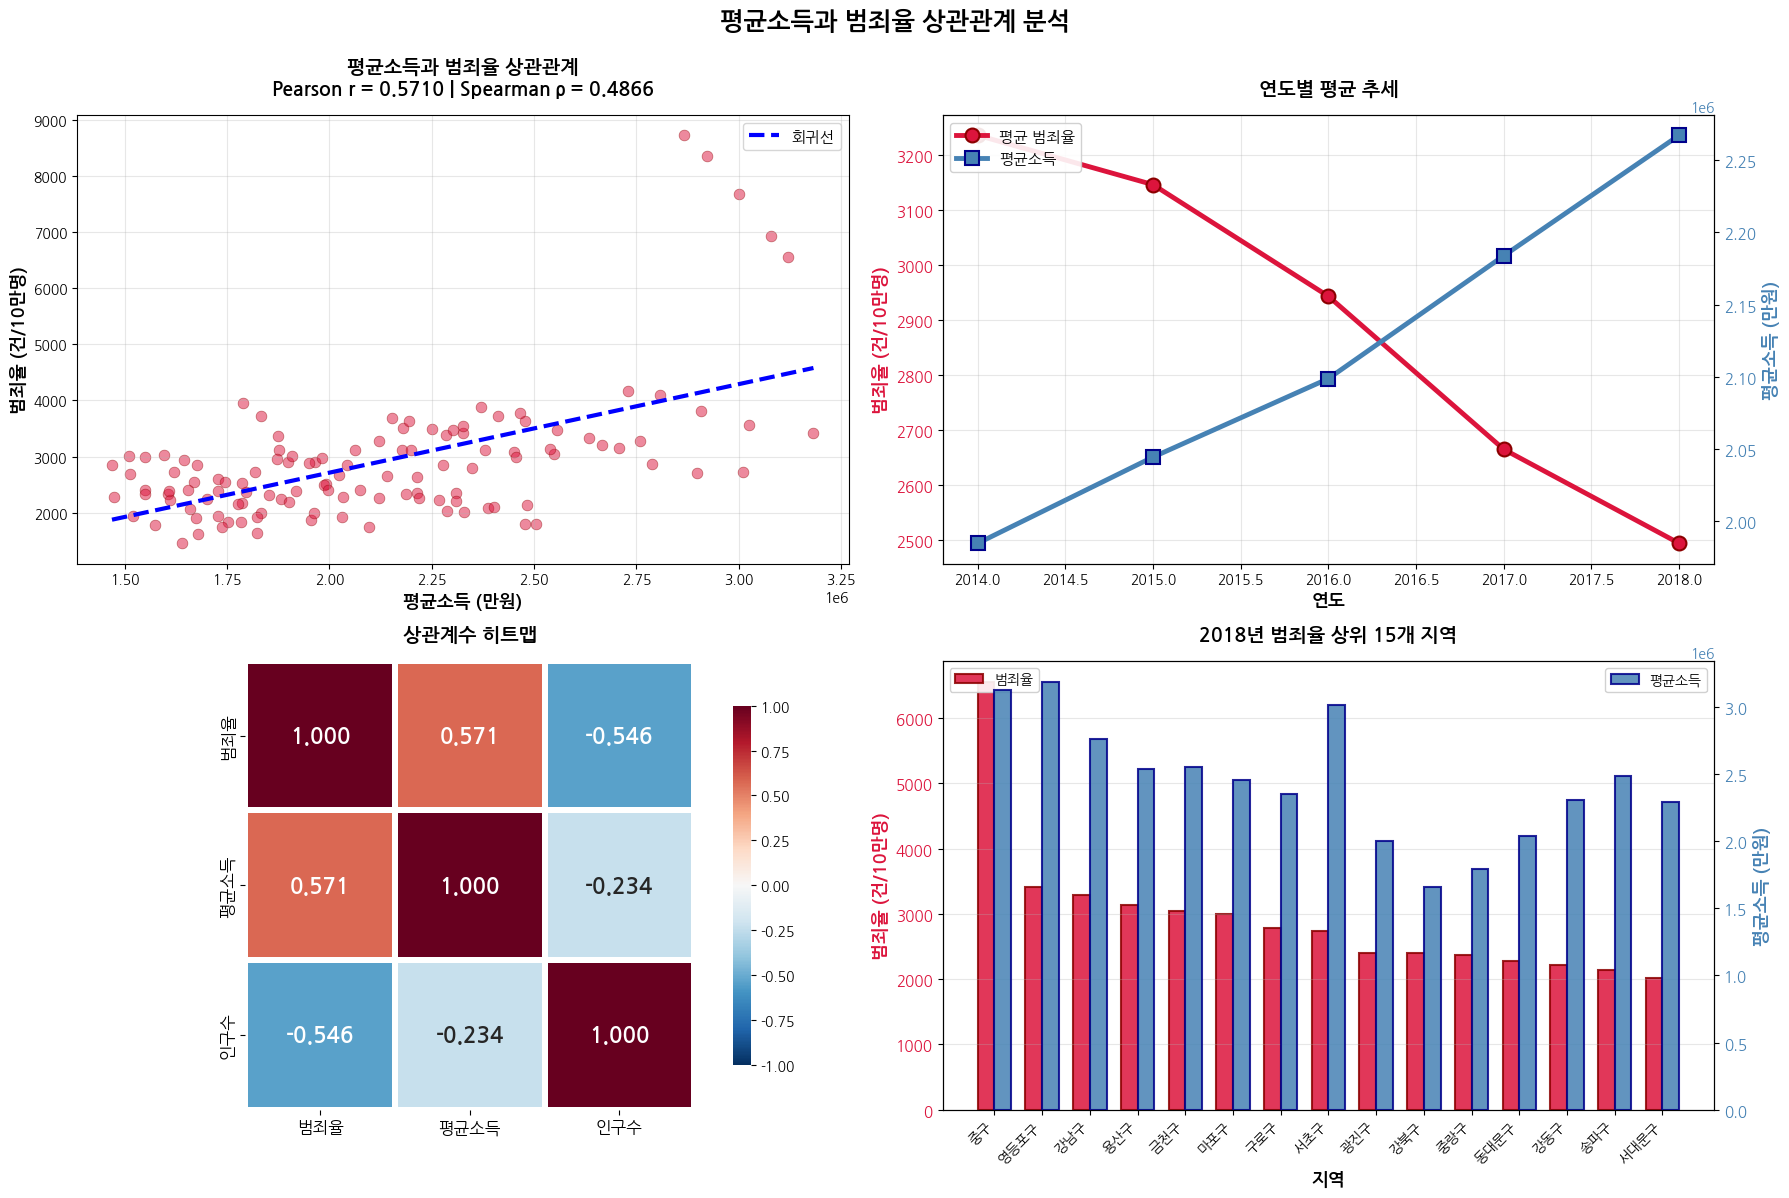

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

# ======================================================
# 1. CSV 데이터 로딩
# ======================================================
csv_file = 'income_crime_merged.csv'

try:
    df_merged = pd.read_csv(csv_file, encoding='utf-8-sig')
    print("=" * 60)
    print("✓ CSV 로딩 완료")
    print("=" * 60)
    print(f"레코드 수: {len(df_merged)}개")
    print(f"분석 연도: {df_merged['연도'].min()} ~ {df_merged['연도'].max()}")
    print(f"분석 지역 수: {df_merged['지역'].nunique()}개")
    print(f"\n컬럼: {df_merged.columns.tolist()}")
    print("\n데이터 샘플:")
    print(df_merged.head())
except FileNotFoundError:
    print(f"오류: {csv_file} 파일을 찾을 수 없습니다.")
    print("먼저 전처리 코드를 실행해주세요.")
    exit()

# ======================================================
# 2. 상관계수 계산
# ======================================================
corr_pearson = df_merged['범죄율'].corr(df_merged['평균소득'])
corr_spearman, spearman_p = stats.spearmanr(df_merged['범죄율'], df_merged['평균소득'])

print("\n" + "=" * 60)
print("전체 기간 상관관계 분석 결과")
print("=" * 60)
print(f"Pearson 상관계수: {corr_pearson:.4f}")
print(f"Spearman 상관계수: {corr_spearman:.4f} (p-value: {spearman_p:.4f})")

# ======================================================
# 3. 시각화 (2x2 레이아웃)
# ======================================================
fig = plt.figure(figsize=(18, 12))

# 1. 산점도 + 회귀선 (전체 기간)
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(df_merged['평균소득'], df_merged['범죄율'],
            alpha=0.5, s=60, c='crimson', edgecolors='darkred', linewidth=0.5)
z = np.polyfit(df_merged['평균소득'], df_merged['범죄율'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_merged['평균소득'].min(), df_merged['평균소득'].max(), 100)
ax1.plot(x_line, p(x_line), "blue", linestyle='--', linewidth=3, label='회귀선')
ax1.set_xlabel('평균소득 (만원)', fontsize=13, weight='bold')
ax1.set_ylabel('범죄율 (건/10만명)', fontsize=13, weight='bold')
ax1.set_title(f'평균소득과 범죄율 상관관계\nPearson r = {corr_pearson:.4f} | Spearman ρ = {corr_spearman:.4f}',
              fontsize=14, weight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# ======================================================
# 4. 연도별 평균 추세 (이중 y축)
# ======================================================
ax2 = plt.subplot(2, 2, 2)
yearly = df_merged.groupby('연도')[['범죄율', '평균소득']].mean()
ax2_twin = ax2.twinx()

line1 = ax2.plot(yearly.index, yearly['범죄율'],
                marker='o', linewidth=3.5, markersize=10,
                color='crimson', label='평균 범죄율', markeredgecolor='darkred', markeredgewidth=1.5)
line2 = ax2_twin.plot(yearly.index, yearly['평균소득'],
                     marker='s', linewidth=3.5, markersize=10,
                     color='steelblue', label='평균소득', markeredgecolor='darkblue', markeredgewidth=1.5)

ax2.set_xlabel('연도', fontsize=13, weight='bold')
ax2.set_ylabel('범죄율 (건/10만명)', fontsize=13, weight='bold', color='crimson')
ax2_twin.set_ylabel('평균소득 (만원)', fontsize=13, weight='bold', color='steelblue')
ax2.set_title('연도별 평균 추세', fontsize=14, weight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='y', labelcolor='crimson', labelsize=11)
ax2_twin.tick_params(axis='y', labelcolor='steelblue', labelsize=11)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left', fontsize=11, framealpha=0.9)

# ======================================================
# 5. 상관계수 히트맵
# ======================================================
ax3 = plt.subplot(2, 2, 3)
corr_matrix = df_merged[['범죄율', '평균소득', '인구수']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, square=True, linewidths=3, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot_kws={'size': 16, 'weight': 'bold'}, ax=ax3)
ax3.set_title('상관계수 히트맵', fontsize=14, weight='bold', pad=15)
ax3.tick_params(labelsize=12)

# ======================================================
# 6. 최신 연도 범죄율 상위 15개 지역
# ======================================================
ax4 = plt.subplot(2, 2, 4)
latest_year = df_merged['연도'].max()
df_latest = df_merged[df_merged['연도'] == latest_year].copy()
df_top = df_latest.nlargest(15, '범죄율')

x = np.arange(len(df_top))
width = 0.35
ax4_twin = ax4.twinx()

bars1 = ax4.bar(x - width/2, df_top['범죄율'], width,
                label='범죄율', color='crimson', alpha=0.85, edgecolor='darkred', linewidth=1.5)
bars2 = ax4_twin.bar(x + width/2, df_top['평균소득'], width,
                     label='평균소득', color='steelblue', alpha=0.85, edgecolor='darkblue', linewidth=1.5)

ax4.set_xlabel('지역', fontsize=13, weight='bold')
ax4.set_ylabel('범죄율 (건/10만명)', fontsize=13, weight='bold', color='crimson')
ax4_twin.set_ylabel('평균소득 (만원)', fontsize=13, weight='bold', color='steelblue')
ax4.set_title(f'{latest_year}년 범죄율 상위 15개 지역', fontsize=14, weight='bold', pad=15)
ax4.set_xticks(x)
ax4.set_xticklabels(df_top['지역'], rotation=45, ha='right', fontsize=10)
ax4.tick_params(axis='y', labelcolor='crimson', labelsize=11)
ax4_twin.tick_params(axis='y', labelcolor='steelblue', labelsize=11)
ax4.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax4_twin.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('평균소득과 범죄율 상관관계 분석',
             fontsize=18, weight='bold', y=0.995)
plt.tight_layout()
plt.show()